See: https://langchain-ai.github.io/langgraph/tutorials/introduction/

In [114]:
# from utils import langgraph
# from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.utils.function_calling import convert_to_openai_function
from typing import Dict, TypedDict, Optional
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain.schema import HumanMessage, AIMessage
from langgraph.graph import END, StateGraph
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
import operator
import functools
from dotenv import load_dotenv
load_dotenv(override=True)
import os
import json 
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from typing import Literal

In [115]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [116]:
llm = ChatGroq(
    temperature=0, 
    model_name="Llama3-8b-8192"
    )

In [117]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


In [118]:
graph_builder.add_node("chatbot", chatbot)

In [119]:
graph_builder.set_entry_point("chatbot")

In [120]:
graph_builder.set_finish_point("chatbot")

In [121]:
graph = graph_builder.compile()

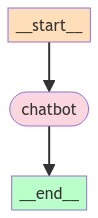

In [122]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [123]:
outputs = []
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Ciao, chi sei ? "
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
):
    print(s)
    outputs.append(s)
    print("----")

{'chatbot': {'messages': [AIMessage(content="Ciao!\n\nGemini è un servizio di ricerca di Google che consente di cercare e scoprire informazioni online in modo più approfondito e personalizzato rispetto alla ricerca tradizionale. Gemini è stato lanciato nel 2020 e si presenta come un'alternativa alla ricerca tradizionale di Google, offrendo risultati più personalizzati e pertinenti.\n\nGemini utilizza un algoritmo di intelligenza artificiale per analizzare le tue ricerche e le tue preferenze per offrire risultati più pertinenti e personalizzati. Inoltre, Gemini utilizza anche i dati delle tue attività online, come ad esempio le tue ricerche precedenti e le tue interazioni con i siti web, per migliorare i risultati delle tue ricerche.\n\nGemini è disponibile solo per gli utenti con un account Google e può essere accessibile solo attraverso il browser Google Chrome.", response_metadata={'token_usage': {'completion_time': 0.170545095, 'completion_tokens': 208, 'prompt_time': 0.004640821, '

In [124]:
print(outputs[-1]['chatbot']['messages'][0].content)

Ciao!

Gemini è un servizio di ricerca di Google che consente di cercare e scoprire informazioni online in modo più approfondito e personalizzato rispetto alla ricerca tradizionale. Gemini è stato lanciato nel 2020 e si presenta come un'alternativa alla ricerca tradizionale di Google, offrendo risultati più personalizzati e pertinenti.

Gemini utilizza un algoritmo di intelligenza artificiale per analizzare le tue ricerche e le tue preferenze per offrire risultati più pertinenti e personalizzati. Inoltre, Gemini utilizza anche i dati delle tue attività online, come ad esempio le tue ricerche precedenti e le tue interazioni con i siti web, per migliorare i risultati delle tue ricerche.

Gemini è disponibile solo per gli utenti con un account Google e può essere accessibile solo attraverso il browser Google Chrome.


# Enhancing the Chatbot with Tools

In [125]:
import sys
sys.path.append('..')
from tools.tavily import web_search_tool as tavily_tool
from tools.retrieval_eventi import get_relevant_document_tool as retrieval_tool

In [126]:
tavily_tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': "Step 1: Define the Graph State. First, we define the state structure for our graph. In this example, our state includes the user's question, the classification of the question, and a response ..."},
 {'url': 'https://langchain-ai.github.io/langgraph/',
  'content': 'LangGraph is framework agnostic (each node is a regular python function). It extends the core Runnable API (shared interface for streaming, async, and batch calls) to make it easy to: Seamless state management across multiple turns of conversation or tool usage. The ability to flexibly route between nodes based on dynamic criteria.'},
 {'url': 'https://langchain-ai.github.io/langgraph/concepts/',
  'content': "If a node has multiple out-going edges, all of those destination nodes will be executed in parallel as a part of the next superstep. State Management¶ LangGraph introduces two key ideas to state management: sta

In [127]:
tools = [tavily_tool]

The results are page summaries our chat bot can use to answer questions.

We need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a **BasicToolNode** that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [128]:
from langgraph.prebuilt import ToolNode #see later

In [129]:

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [130]:
tool_node = BasicToolNode(tools=tools)

In [131]:
graph_builder.add_node("tools", tool_node)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


## Edges

edges route the control flow from one node to the next

Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state.
These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

In [132]:
def router(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    route_tools checks for tool_calls in the chatbot's output. 
    Provide this function to the graph by calling add_conditional_edges, 
    which tells the graph that whenever the chatbot node completes
    to check this function to see where to go next.

    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.

    
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [133]:
graph_builder.add_conditional_edges(
    "chatbot",
    router,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {
        "tools": "tools", 
        "__end__": "__end__"
    },
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


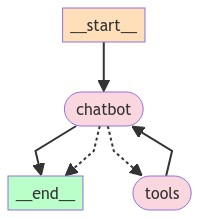

In [134]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [135]:
outputs = []
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Ciao, cos'è Gemini di Google ? "
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
):
    print(s)
    outputs.append(s)
    print("----")

{'chatbot': {'messages': [AIMessage(content="Ciao!\n\nGemini è un servizio di ricerca di Google che consente di cercare e scoprire informazioni online in modo più approfondito e personalizzato rispetto alla ricerca tradizionale. Gemini è stato lanciato nel 2020 e si presenta come un'alternativa alla ricerca tradizionale di Google, offrendo risultati più personalizzati e pertinenti.\n\nGemini utilizza un algoritmo di intelligenza artificiale per analizzare le tue ricerche e le tue preferenze per offrire risultati più pertinenti e personalizzati. Inoltre, Gemini utilizza anche i dati delle tue attività online, come ad esempio le tue ricerche precedenti e le tue interazioni con i siti web, per migliorare i risultati delle tue ricerche.\n\nGemini è disponibile solo per gli utenti con un account Google e può essere accessibile solo attraverso il browser Google Chrome.", response_metadata={'token_usage': {'completion_time': 0.167255444, 'completion_tokens': 208, 'prompt_time': 0.003748013, '

## Memoria

In [136]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [137]:
graph = graph_builder.compile(checkpointer=memory)

# Human in the Loop

In [138]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [139]:
user_input = "Sto imparando a usare LangGraph, puoi cercare alcune informazioni relative a esso?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Sto imparando a usare LangGraph, puoi cercare alcune informazioni relative a esso?
================================== Ai Message ==================================

LangGraph è un framework di rappresentazione e analisi di grafi per linguaggi naturali. Ecco alcune informazioni relative a LangGraph:

**Cos'è LangGraph?**

LangGraph è un framework open-source per la rappresentazione e l'analisi di grafi per linguaggi naturali. È stato sviluppato da un team di ricercatori dell'Università di Stanford e dell'Università di California, Berkeley.

**Funzionalità**

LangGraph offre diverse funzionalità per la rappresentazione e l'analisi di grafi per linguaggi naturali, tra cui:

* Rappresentazione di grafi per linguaggi naturali, come ad esempio grafi di sintassi, grafi di semantica e grafi di pragmatica.
* Analisi di grafi per identificare strutture linguistiche, come ad esempio frasi, proposizioni e argomenti.
